# Etude des données sur le coronavirus en France
## source des données : DATA.GOUV

In [257]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

## Lecture du fichier

In [258]:
df_raw = pd.read_csv("donnees-hospitalieres-covid19-2021-02-03-19h03.csv", sep=";")
df = df_raw.astype({'sexe': 'int8','hosp': 'int32','rea': 'int32','rad': 'int32','dc': 'int32'})
df.head()

,dep,sexe,jour,hosp,rea,rad,dc
0,01,0,2020-03-18,2,0,1,0
1,01,1,2020-03-18,1,0,1,0
2,01,2,2020-03-18,1,0,0,0
3,02,0,2020-03-18,41,10,18,11
4,02,1,2020-03-18,19,4,11,6


## Regrouppement des données par jour indépendamment du sexe et du département

In [259]:
df_global = pd.DataFrame(columns = list(df.columns)).drop(columns = 'sexe').drop(columns = 'dep')
df_global = df_global.astype({'hosp': 'int32','rea': 'int32','rad': 'int32','dc': 'int32'})
index = 0
rows = []
for jour in df['jour'].unique():
    rows.append([jour, sum([nombre for nombre in df[df.jour == jour].hosp]), sum([nombre for nombre in df[df.jour == jour].rea]),sum([nombre for nombre in df[df.jour == jour].rad]),sum([nombre for nombre in df[df.jour == jour].dc])]) 
for row in rows:
    df_global.loc[index] = row
    index +=1
df_global.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 323 entries, 0 to 322
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   jour    323 non-null    object
 1   hosp    323 non-null    int64 
 2   rea     323 non-null    int64 
 3   rad     323 non-null    int64 
 4   dc      323 non-null    int64 
dtypes: int64(4), object(1)
memory usage: 15.1+ KB


## Mise en format de la date

In [260]:
df_global.jour = pd.to_datetime(df_global['jour'], format='%Y-%m-%d')

## Ajout de colonnes correspondantes au nombre de décès par jour & l'évolution du nombre de personnes hospitalisées

<AxesSubplot:title={'center':'Evolution jounalière du nombre de patiens hospitalisés'}, ylabel='+- patiens hospitalisés'>

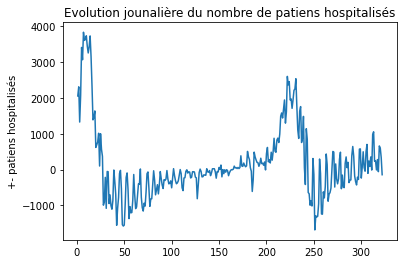

In [261]:
df_global['jDc'] = df_global['dc'] - df_global['dc'].shift(+1)
df_global['jHosp'] = df_global['hosp'] - df_global['hosp'].shift(+1)
df_global = df_global.dropna()
df_global.jHosp.plot(title="Evolution jounalière du nombre de patiens hospitalisés", ylabel = '+- patiens hospitalisés')

## Visualisation des données de décès par jour et nombre d'entrées en réanimation

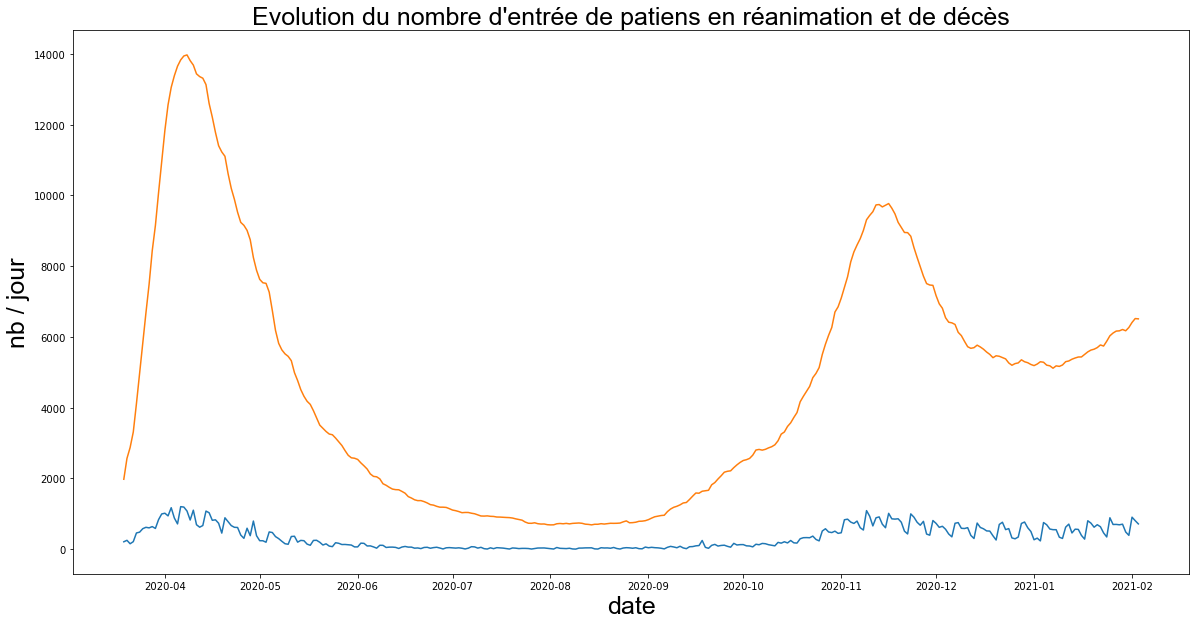

In [262]:

font = {'family': 'arial',
        'weight': 'normal',
        'size': 25,
        }
plt.figure(figsize=(20,10))
plt.plot(df_global.jour,df_global.jDc)
plt.plot(df_global.jour,df_global.rea)
plt.title("Evolution du nombre d'entrée de patiens en réanimation et de décès", fontdict=font)
plt.ylabel('nb / jour', fontdict=font)
plt.xlabel('date', fontdict=font)
plt.show()

## Etude de la correlation entre le nombre de décès et l'évolution du nombre de personnes hospitalisées

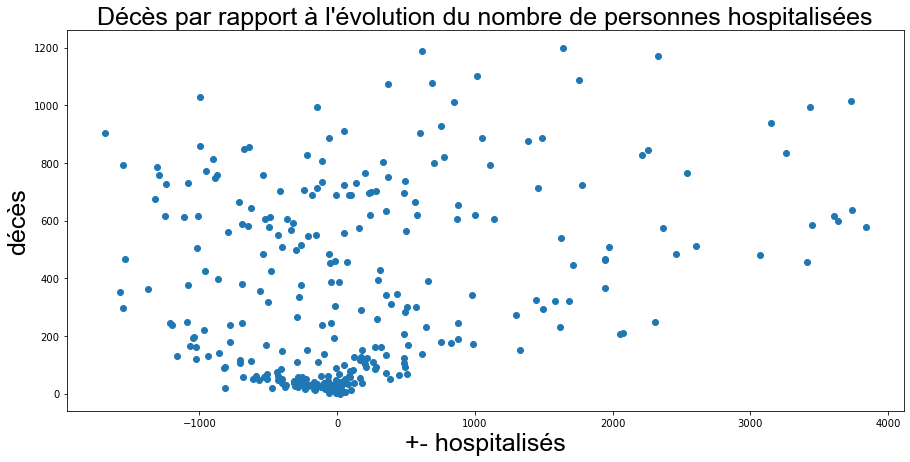

In [263]:
plt.figure(figsize=(15,7))
plt.title("Décès par rapport à l'évolution du nombre de personnes hospitalisées", fontdict=font)
plt.xlabel('+- hospitalisés', fontdict=font)
plt.ylabel('décès', fontdict=font)
plt.scatter(df_global.jHosp,df_global.jDc)
plt.show()

### Nous remarquons que la correlation ne smble pas être très pronnoncée, nous allons vérifier en calculant sa valeur

In [264]:
df_global['jDc'].corr(df_global['jHosp'])

0.27221842006512276

## Etudions l'évolution de la correlation en introduisant un décallage
### Nous pouvons en effet imaginer qu'il y a une certain temps avant que les personnes hospitalisées ne risquent de décéder.

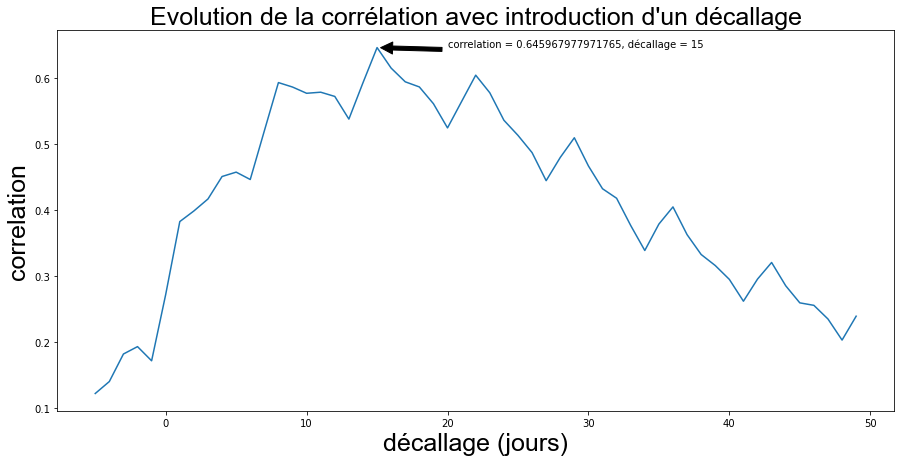

In [265]:
plt.figure(figsize=(15,7))
plt.title("Evolution de la corrélation avec introduction d'un décallage", fontdict=font)
plt.ylabel('correlation', fontdict=font)
plt.xlabel('décallage (jours)', fontdict=font)
corelations = [df_global['jDc'].corr(df_global['jHosp'].shift(decallage)) for decallage in  list(range(-5,50))] 
plt.plot(list(range(-5,50)),corelations)
plt.annotate('correlation = ' + str(max(corelations))+ ', décallage = ' + str(list(range(-5,50))[corelations.index(max(corelations))]), xy=(list(range(-5,50))[corelations.index(max(corelations))], max(corelations)), xytext=(list(range(-5,50))[corelations.index(max(corelations))] + 5,  max(corelations)),arrowprops=dict(facecolor='black', shrink=0.05),)
plt.show()

### Nous pouvons en déduire que le décallage qui nous donne une correlation maximum entre nombre journalier de décès et évolution journalière du nombre de personnes hospitalisées atteint son maximum pour un décallage de 15 jours.

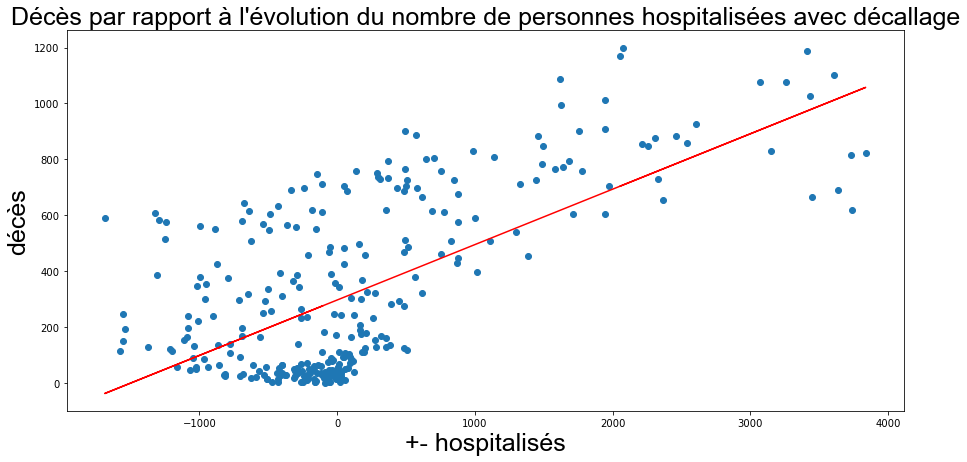

In [266]:
linReg = LinearRegression()
linReg.fit(df_global.jHosp.shift(15).iloc[15:].values.reshape(-1,1),df_global.jDc.iloc[15:])
yReg = linReg.predict(df_global.jHosp.shift(15).iloc[15:].values.reshape(-1,1))
plt.figure(figsize=(15,7))
plt.title("Décès par rapport à l'évolution du nombre de personnes hospitalisées avec décallage", fontdict=font)
plt.xlabel('+- hospitalisés', fontdict=font)
plt.ylabel('décès', fontdict=font)
plt.plot(df_global.jHosp.shift(15).iloc[15:].values.reshape(-1,1),yReg, color='red')
plt.scatter(df_global.jHosp.shift(15),df_global.jDc)
plt.show()

### Nous remarquons que la corrélation semble bien plus pronnoncée avec ce décallage, ce qui est vérifié quand nous effectuons le calcul.

In [267]:
df_global['jDc'].corr(df_global['jHosp'].shift(15))

0.645967977971765